In [1]:
# julia version of stability lp tester
using SCS
using Ipopt
using Hypatia
using COSMO
using Clarabel
using Mosek
using Convex
using Plots

unif(m) = [1/m for i in 1:m]

unif (generic function with 1 method)

uses Convex.jl to run an entropy-regularized LP, then return the value of x1 at opt. it's an LP relaxation of set cover on a simple 1 element universe with m copies of the set containing that element. so you just have to pick the least-weight copy.

version 1: before getting fancy, let's try and understand what the stability is going to be like if we do a simple unweighted entropy regularizer. in this version, we minimize <x,w> - entropy(x) / minimum(w). the normalization is chosen because x should be roughly uniform, so the entropy should be roughly log(m), and the minimum weight should be roughly 1/m.

In [7]:
function get_x1_value(m,w,solver)
    x = Variable(m)
#    wprime = w / (2 * minimum(w))
#    B = 2 * minimum(w)/ log(m)
    constraints = [sum(x) >= 1, x >= 0]
    p = minimize(dot(w,x) - entropy(x) / ( log(m) * minimum(w)), constraints, numeric_type=BigFloat)
    solve!(p, solver.Optimizer{BigFloat}, silent=true)
    return evaluate(x)[1]
end


get_x1_value (generic function with 1 method)

first let's try and figure out the sensitivity with respect to a perturbation of w1, of size delta << 1/m. first let's see if the effect is linear in delta, or something else.

In [11]:
m = 10 


function perturb_by_delta(m,delta)
    w = unif(m)
    w[1] -= delta
    return w
end

results = [abs(get_x1_value(m, unif(m),SCS) - get_x1_value(m, perturb_by_delta(m,delta), SCS)) / (delta )  for delta in deltas]
plot(deltas, results, xlabel="delta", ylabel="Difference", title="Results Plot", legend=false)

TypeError: TypeError: in Type{...} expression, expected UnionAll, got Type{SCS.Optimizer}

Weird curve. Can we replicate with other solvers?

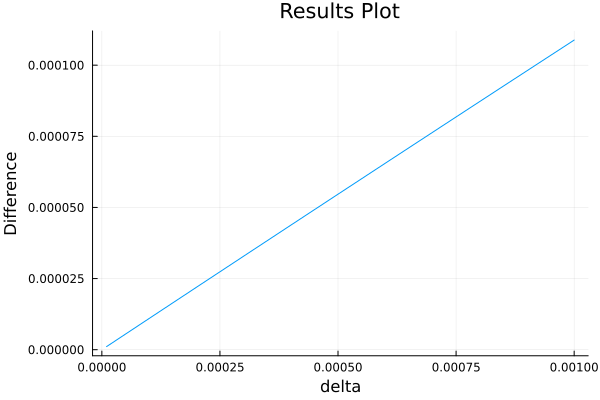

In [24]:
deltas = 0.00001:0.00001:0.001
m=20
results = [abs(get_x1_value(m, unif(m),Clarabel) - get_x1_value(m, perturb_by_delta(m,delta), Clarabel))   for delta in deltas]
plot(deltas, results, xlabel="delta", ylabel="Difference", title="Results Plot", legend=false)

Oh, no...Clarabel says something different. And more plausible...

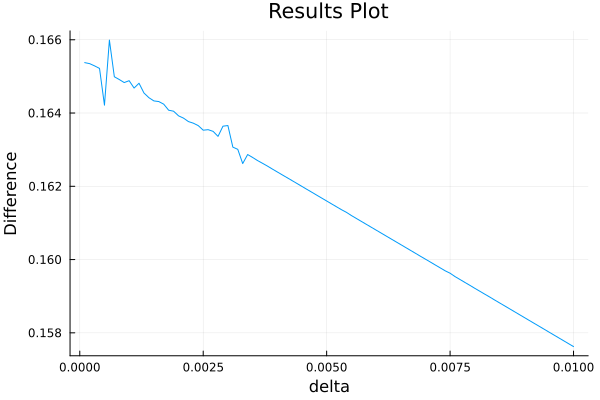

In [5]:
results = [abs(get_x1_value(m, unif(m),COSMO) - get_x1_value(m, perturb_by_delta(m,delta), COSMO)) / (delta )  for delta in deltas]
plot(deltas, results, xlabel="delta", ylabel="Difference", title="Results Plot", legend=false)

Oh no...COSMO gives a third different answer

In [9]:
setprecision(BigFloat,512)

512

In [ ]:
# OLD, JUMP VERSION

function run_trial(m,w)

    # Define the LP model
    model = Model(() -> Convex.Optimizer(Clarabel.Optimizer))

    alpha = 2 * minimum(w) # UPDATE THIS
    B = alpha / log(m)


    @variable(model, x[1:m] >= 0)

    @constraint(model, sum(x) >= 1)

    # the following function takes a vector of variables, x, and a vector
    # of nonnegative weights, w, and returns the weighted entropy, defined to be
    # sum w_i x_i log(1 / w_i x_i)
#    function entropy(x, w)
#        return sum([w[i] * x[i] * log(alpha / (w[i] * x[i])) / alpha for i in 1:length(x)])
#    end

#    function entropy(x, w)
#        return sum([w[i] * (x[i] * log(1 / x[i]) + (1-x[i]) * log(1 / (1 - x[i]))) for i in 1:length(x)])
#    end

    function set_cover_objective(x,w)
        return sum([w[i] * x[i] for i in 1:length(x)])
    end

#    @constraint(model, set_cover_objective(x, w) <= alpha)

    # Define the objective function
    @objective(model, Min, set_cover_objective(x, w) - B * entropy([ x[i] * w[i] / alpha for i in 1:m]))

    # Solve the LP problem
    optimize!(model)

    print(m)

    return value(x[1])
end
